In [124]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F 
from torch.utils.data import DataLoader, TensorDataset

In [125]:
import pandas as pd
import numpy as np
import os
#import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
Debug = False

In [126]:
import matplotlib.pyplot as plt

### 模型定义

In [127]:
# 定义LSTM模型
class LSTMModel(nn.Module):
    def __init__(self, conv_input, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.conv=nn.Conv1d(conv_input,conv_input,1)
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True).to(device)
        
        
        self.fc = nn.Linear(hidden_size, output_size)
        self.num_layers = num_layers
        self.hidden_dim = hidden_size
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        x=self.conv(x)
        
        h0 = torch.randn((self.num_layers, x.shape[0], self.hidden_dim)).to(device) # 初始化隐藏状态
        c0 = torch.randn((self.num_layers, x.shape[0], self.hidden_dim)).to(device) # 初始化细胞状态
        
        output, _ = self.lstm(x,(h0,c0))
        output = self.dropout(output)
        output = self.fc(output[:, -1, :]) 
        return output

### 导入数据

In [128]:
# 创建一个空列表来存储读取的 DataFrames
dataframes_RUL = []
dataframes_EIS = []

# 使用循环读取文件并分配名称
for i in range(1, 9):
    # 构建文件名
    file_name_cap= f"Capacity_data/Data_Capacity_25C{i:02}.txt"
    file_name_EIS = f"EIS_data/EIS_state_V_25C{i:02}.txt"  # 使用状态V
    
    
    if not os.path.isfile(file_name_cap):
        print(f"Cap文件 {file_name_cap} 不存在，跳过...")
        continue
    elif not os.path.isfile(file_name_EIS):
        print(f"EIS文件 {file_name_EIS} 不存在，跳过...")
        continue

    # 读取文件并添加到列表
    df_cap = pd.read_csv(file_name_cap, sep="\t")
    df_EIS = pd.read_csv(file_name_EIS, sep="\t")
    #print(df_cap.columns)
    
    if i == 1 or i==5:
        cap_number = 3
    else:
        cap_number = 5
    #剔除表现不佳的数据
    if i == 2 or i == 4 or i == 7 or i == 8:
        continue
    cycle = []
    cap = []
    eis = []
    cycle_max = df_cap[df_cap.columns[1]].max()
    cycle_max2 = df_EIS[df_EIS.columns[1]].max()
    cycle_number = min(cycle_max,cycle_max2)
    
    max_scale = df_cap[df_cap[df_cap.columns[1]]==1][df_cap.columns[cap_number]][:].max()
    for i in range(1,int(cycle_number)+1):
        temp = df_cap[df_cap[df_cap.columns[1]]==i][df_cap.columns[cap_number]][-1:].max()
        temp_EIS_Re = np.array(df_EIS[df_EIS[df_EIS.columns[1]]==i][df_EIS.columns[3]][:])
        temp_EIS_Im = np.array(df_EIS[df_EIS[df_EIS.columns[1]]==i][df_EIS.columns[4]][:])
        temp = temp/max_scale
        cycle.append(i)
        cap.append(temp)
        eis.append(np.concatenate((temp_EIS_Re, temp_EIS_Im), axis=0))
        #将小于0.8的部分制成RUL
        if temp<0.8:
            break
    
    cycle.reverse()
    dataframes_RUL.append(cycle)
    dataframes_EIS.append(eis)

In [129]:
#将35数据读入

# 使用循环读取文件并分配名称
for i in range(1, 3):
    # 构建文件名
    file_name_cap= f"Capacity_data/Data_Capacity_35C{i:02}.txt"
    file_name_EIS = f"EIS_data/EIS_state_V_35C{i:02}.txt"  # 使用状态V
    
    
    if not os.path.isfile(file_name_cap):
        print(f"Cap文件 {file_name_cap} 不存在，跳过...")
        continue
    elif not os.path.isfile(file_name_EIS):
        print(f"EIS文件 {file_name_EIS} 不存在，跳过...")
        continue

    # 读取文件并添加到列表
    df_cap = pd.read_csv(file_name_cap, sep="\t")
    df_EIS = pd.read_csv(file_name_EIS, sep="\t")
    #print(df_cap.columns)
    cap_number = 3
    
    cycle = []
    cap = []
    eis = []
    cycle_max = df_cap[df_cap.columns[1]].max()
    cycle_max2 = df_EIS[df_EIS.columns[1]].max()
    cycle_number = min(cycle_max,cycle_max2)
    
    
    #max_scale = df_cap[df_cap[df_cap.columns[1]]==1][df_cap.columns[cap_number]][-1:].max()
    for i in range(1,int(cycle_number)+1):
        temp = df_cap[df_cap[df_cap.columns[1]]==i][df_cap.columns[cap_number]][-1:].max()
        temp_EIS_Re = np.array(df_EIS[df_EIS[df_EIS.columns[1]]==i][df_EIS.columns[3]][:])
        temp_EIS_Im = np.array(df_EIS[df_EIS[df_EIS.columns[1]]==i][df_EIS.columns[4]][:])
        temp = temp/max_scale
        cycle.append(i)
        cap.append(temp)
        eis.append(np.concatenate((temp_EIS_Re, temp_EIS_Im), axis=0))
        if temp<0.8:
            break
    
    cycle.reverse()
    dataframes_RUL.append(cycle)
    dataframes_EIS.append(eis)

In [130]:
#将45数据读入
for i in range(1, 3):
    # 构建文件名
    file_name_cap= f"Capacity_data/Data_Capacity_45C{i:02}.txt"
    file_name_EIS = f"EIS_data/EIS_state_V_45C{i:02}.txt"  # 使用状态V
    
    
    if not os.path.isfile(file_name_cap):
        print(f"Cap文件 {file_name_cap} 不存在，跳过...")
        continue
    elif not os.path.isfile(file_name_EIS):
        print(f"EIS文件 {file_name_EIS} 不存在，跳过...")
        continue

    # 读取文件并添加到列表
    df_cap = pd.read_csv(file_name_cap, sep="\t")
    df_EIS = pd.read_csv(file_name_EIS, sep="\t")
    #print(df_cap.columns)
    cap_number = 3
    
    cycle = []
    cap = []
    eis = []
    cycle_max = df_cap[df_cap.columns[1]].max()
    cycle_max2 = df_EIS[df_EIS.columns[1]].max()
    cycle_number = min(cycle_max,cycle_max2)
    
    
    #max_scale = df_cap[df_cap[df_cap.columns[1]]==1][df_cap.columns[cap_number]][-1:].max()
    for i in range(1,int(cycle_number)+1):
        temp = df_cap[df_cap[df_cap.columns[1]]==i][df_cap.columns[cap_number]][-1:].max()
        temp_EIS_Re = np.array(df_EIS[df_EIS[df_EIS.columns[1]]==i][df_EIS.columns[3]][:])
        temp_EIS_Im = np.array(df_EIS[df_EIS[df_EIS.columns[1]]==i][df_EIS.columns[4]][:])
        temp = temp/max_scale
        cycle.append(i)
        cap.append(temp)
        eis.append(np.concatenate((temp_EIS_Re, temp_EIS_Im), axis=0))
        if temp<0.8:
            break
    
    cycle.reverse()
    dataframes_RUL.append(cycle)
    dataframes_EIS.append(eis)

In [131]:
X = []
y = []
for i in range(0,len(dataframes_RUL)):
    for j in range(len(dataframes_RUL[i])):
        X.append(dataframes_EIS[i][j])
        y.append(dataframes_RUL[i][j])
X = np.array(X)
y = np.array(y)
print(X.shape,y.shape)

(1530, 120) (1530,)


In [132]:
# 将EIS的每个实部和每个虚部分别各自归一化
remax = []
immax = []
data={}
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
y = y.reshape(-1,1)
# 对标签也进行归一化
y = scaler.fit_transform(y)
# 将每份电池单独制作，便于交叉训练和验证, 
start = 0
for i in range(len(dataframes_RUL)):
    feature_name = f'EIS{i+1:02}'
    target_name = f'Cap{i+1:02}'
    n = len(dataframes_RUL[i])
    X_r = X[start:start+n,:60].copy()#将实部整体进行归一化
    X_r_flat = X_r.flatten()
    #取第一个EIS的最大最小值
    X_r_min = X_r_flat[:60].min()
    
    X_r_max = X_r_flat[:60].max()
    remax.append(X_r_flat[:].max()/X_r_max)
    normalized_Xr_flat = ((X_r_flat.reshape(-1, 1))-X_r_min)/(X_r_max-X_r_min)
    #normalized_Xr_flat = scaler.fit_transform(X_r_flat.reshape(-1, 1))  
    normalized_Xr_data = normalized_Xr_flat.reshape(X[start:start+n,:60].shape)
    
    X_i = X[start:start+n,60:]
    X_i_flat = X_i.flatten()
    X_i_min = X_i_flat[:60].min()
    X_i_max = X_i_flat[:60].max()

    immax.append(X_i_flat[:].max()/X_i_max)
    #normalized_Xi_flat = scaler.fit_transform(X_i_flat.reshape(-1, 1)) 
    normalized_Xi_flat = ((X_i_flat.reshape(-1, 1))-X_i_min)/(X_i_max-X_i_min)
    normalized_Xi_data = normalized_Xi_flat.reshape(X[start:start+n,60:].shape)
    data[feature_name] = np.concatenate((normalized_Xr_data, normalized_Xi_data), axis=1)
    data[feature_name] = data[feature_name].reshape(-1,2, 60)#将数据形式转换为（batch，60，2），实部和虚部作为一个整体特征
    data[feature_name] = data[feature_name].transpose(0, 2, 1)
    data[target_name] = y[start:start+n].reshape(-1,1)
    start += n
# print(remax,np.mean(remax))
# print(immax,np.mean(immax))

In [133]:
if Debug:
    # 检查数据效果
    for i in range(15,20):
        x_plot = data["EIS01"][i][:60]
        y_plot = data["EIS01"][i][60:]
        plt.plot(x_plot, y_plot)
    plt.show()

In [134]:
if Debug:
    # 检查数据效果
    for i in range(15,20):
        x_plot = data["Cap02"][:]
        plt.plot(x_plot)
    plt.show()

In [135]:
start = 0
for i in range(2,9):
    if i == 2:
        trainning_data = data[f"EIS{i:02}"][start:].copy()
        trainning_target = data[f"Cap{i:02}"][start:].copy()
    #剔除测试集
    elif i!=1 and i!=5 and i!= 8:
    #else:
        trainning_data = np.vstack((trainning_data,data[f"EIS{i:02}"][start:]))
        trainning_target = np.vstack((trainning_target,data[f"Cap{i:02}"][start:]))
#     else:
#         trainning_data = np.vstack((trainning_data,data[f"EIS{i:02}"][:10]))
#         trainning_target = np.vstack((trainning_target,data[f"Cap{i:02}"][:10]))

In [136]:
trainning_data = torch.tensor(trainning_data, dtype=torch.float32)
trainning_target = torch.tensor(trainning_target, dtype=torch.float32)

In [137]:
# dataset = TensorDataset(trainning_data, trainning_target)
# dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

### Train process

In [138]:
# 初始化模型、损失函数和优化器
input_size = 2 # 特征数量
hidden_size = 128
num_layers = 5
output_size = 1
conv_input = 60
batch_size = 64
epochs = 3000
n_splits = 5

In [139]:
from sklearn.model_selection import KFold  

In [140]:
# # 训练模型
# #model.load_state_dict(torch.load('model_weights/model_weights.pth'))
# model = LSTMModel(conv_input, input_size, hidden_size, num_layers, output_size) 
# model = model.to(device)
# criterion = nn.MSELoss() 
# optimizer = optim.Adam(model.parameters(), lr=1e-4)
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.8, patience=40, verbose=True, min_lr=1e-5)
# #optimizer = optim.Adam(model.parameters(), lr=0.0001,betas=(0.5,0.999))  
# for epoch in range(epochs):
#     model.train()
#     for batch_X, batch_y in dataloader:
#         batch_X, batch_y = batch_X.to(device), batch_y.to(device)
#         optimizer.zero_grad()
#         outputs = model(batch_X)
#         loss = criterion(outputs, batch_y)
#         loss.backward()
#         optimizer.step()
    
#     # 在验证集上评估模型
# #     model.eval()
# #     with torch.no_grad():
# #         test_data, test_target = test_data_811.to(device), test_target_811.to(device)
# #         val_outputs = model_811(test_data_811[:100])
# #         val_loss = criterion(val_outputs, test_target_811[:100])
#     if epoch%100 ==0:
#         print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item()}')
# torch.save(model.state_dict(), 'model_weights/test.pth')


In [141]:
import gc
def gc_collect():
    gc.collect()
    torch.cuda.empty_cache()
gc_collect()

In [142]:
kf = KFold(n_splits=n_splits, shuffle=True)

model_number = 0
for train_idx, val_idx in kf.split(trainning_data):  
    train_X, val_X = trainning_data[train_idx], trainning_data[val_idx]  
    train_y, val_y = trainning_target[train_idx], trainning_target[val_idx]  
    train_dataset = TensorDataset(train_X, train_y)  
    val_dataset = TensorDataset(val_X, val_y)  
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)  
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)  
    model = LSTMModel(conv_input, input_size, hidden_size, num_layers, output_size) 
    model = model.to(device)
    criterion = nn.MSELoss()   
    optimizer = optim.Adam(model.parameters(), lr=0.0001,betas=(0.5,0.999))  
     
    for epoch in range(epochs):
        model.train() 
        for i, (inputs, labels) in enumerate(train_loader):  
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()  
            outputs = model(inputs)  
            loss = criterion(outputs, labels)  
            loss.backward()  
            optimizer.step()  
        model.eval()
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                outputs = model(inputs)  
                val_loss = criterion(outputs, labels)    
        if epoch%100 ==0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item()}, Validation Loss: {val_loss.item()}') 
    torch.save(model.state_dict(), f"model_weights/CNNBiLSTM/test_rul{model_number}.pth")
    model_number += 1

Epoch [1/3000], Loss: 0.1776696741580963, Validation Loss: 0.152461439371109
Epoch [101/3000], Loss: 0.007704812567681074, Validation Loss: 0.0036581256426870823
Epoch [201/3000], Loss: 0.006371623370796442, Validation Loss: 0.0009950974490493536
Epoch [301/3000], Loss: 0.00639970600605011, Validation Loss: 0.0009415642125532031
Epoch [401/3000], Loss: 0.007366705220192671, Validation Loss: 0.0007267861510626972
Epoch [501/3000], Loss: 0.004742401652038097, Validation Loss: 0.0011811364674940705
Epoch [601/3000], Loss: 0.04448942095041275, Validation Loss: 0.015614896081387997
Epoch [701/3000], Loss: 0.004496138542890549, Validation Loss: 0.00048483762657269835
Epoch [801/3000], Loss: 0.0014241196913644671, Validation Loss: 0.0002836044004652649
Epoch [901/3000], Loss: 0.0015157413436099887, Validation Loss: 0.0002018012455664575
Epoch [1001/3000], Loss: 0.001442538108676672, Validation Loss: 0.0002460344403516501
Epoch [1101/3000], Loss: 0.0007732019876129925, Validation Loss: 0.00019

Epoch [601/3000], Loss: 0.0016236798837780952, Validation Loss: 0.0009176991297863424
Epoch [701/3000], Loss: 0.0033173169940710068, Validation Loss: 0.0021034495439380407
Epoch [801/3000], Loss: 0.001582967466674745, Validation Loss: 0.0007215779623948038
Epoch [901/3000], Loss: 0.0035611335188150406, Validation Loss: 0.0009144766954705119
Epoch [1001/3000], Loss: 0.0021030143834650517, Validation Loss: 0.0002104419399984181
Epoch [1101/3000], Loss: 0.0027310270816087723, Validation Loss: 0.0018222922226414084
Epoch [1201/3000], Loss: 0.001716443570330739, Validation Loss: 0.002676070900633931
Epoch [1301/3000], Loss: 0.0020451436284929514, Validation Loss: 0.00019947746477555484
Epoch [1401/3000], Loss: 0.0012518322328105569, Validation Loss: 0.0016991423908621073
Epoch [1501/3000], Loss: 0.0014866009587422013, Validation Loss: 0.00020668598881457
Epoch [1601/3000], Loss: 0.001706405426375568, Validation Loss: 0.00021411236957646906
Epoch [1701/3000], Loss: 0.0014141154242679477, Val

In [143]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import math

train RMSE:  0.044911150283464644
train R2:  0.8986494954111574


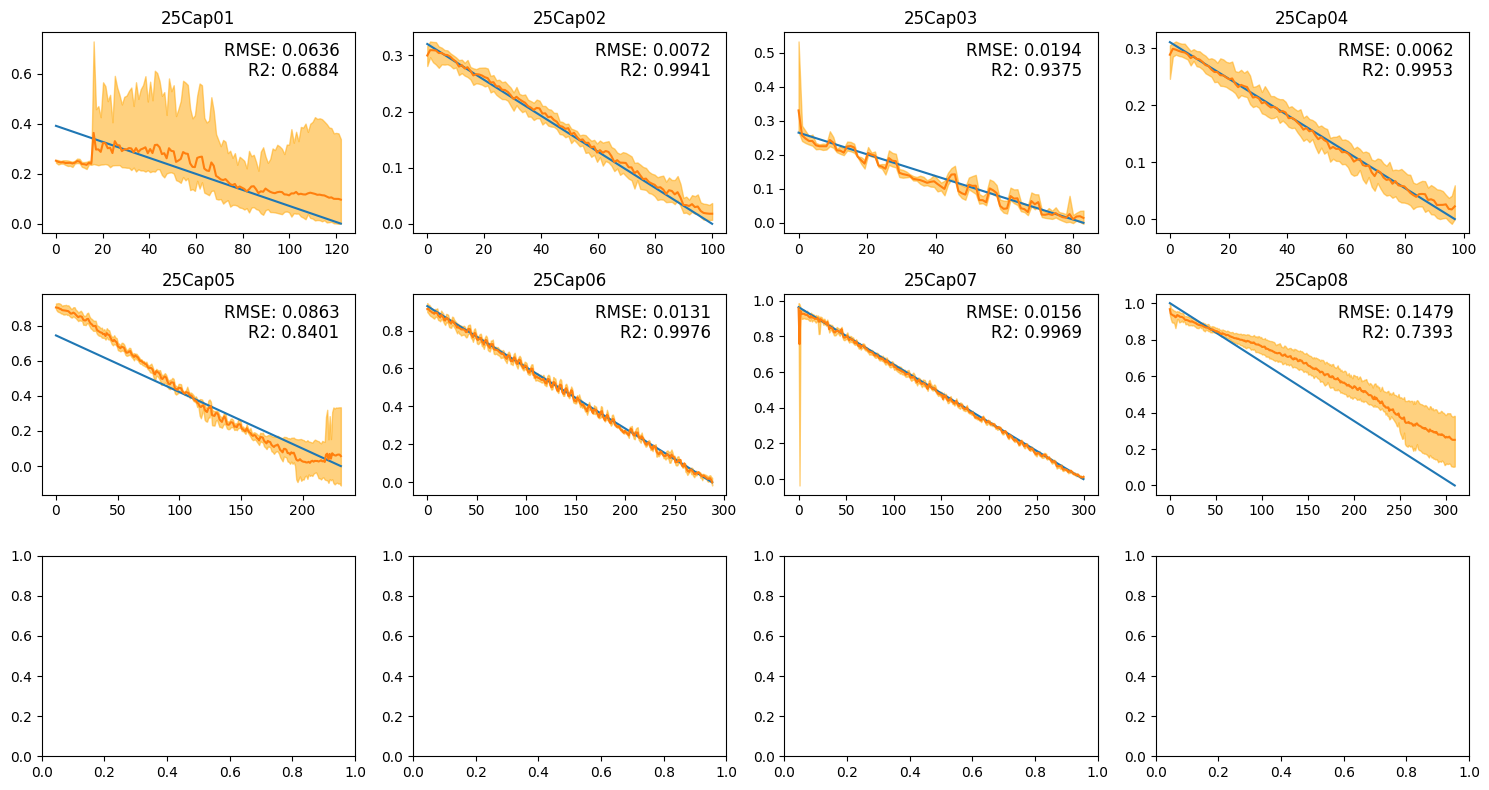

In [144]:
# 创建画布  
fig, axs = plt.subplots(nrows=3, ncols=4, figsize=(15, 8))  
ID = 1
flag = 0
title_name = 1
start = 0
mean_RMSE_train = 0
mean_RMSE_test = 0
mean_R2_train = 0
mean_R2_test = 0
# 在每个小区域中绘制图像  
for i in range(3):  
    for j in range(4):
        result = []
        x = torch.tensor(data[f"EIS{ID:02}"], dtype=torch.float32)
        for k in range(n_splits):
            model.load_state_dict(torch.load(f"model_weights/CNNBiLSTM/test_rul{k}.pth",
                                              map_location=torch.device(device)))
            out = model(x.to(device))
            out = out.cpu()
            out = out.detach().numpy()
            result.append(out)
        result = np.array(result)
        out = np.mean(result, axis=0)
        out_upper = np.max(result, axis=0)
        out_upper = np.squeeze(out_upper)
        out_lower = np.min(result, axis=0)
        out_lower = np.squeeze(out_lower)
        true = data[f"Cap{ID:02}"]
        MSE = mean_squared_error(out[start:], true[start:]) 
        R2_result = r2_score(true[start:], out[start:]) 
        RMSE_result = math.sqrt(MSE)
        mean_RMSE_train += RMSE_result
        mean_R2_train += R2_result
        RMSE_str = "{:.4f}".format(RMSE_result)
        R2_str = "{:.4f}".format(R2_result)
        x = np.linspace(0,x.shape[0],x.shape[0])
        axs[i, j].plot(x[start:], true[start:])
        axs[i, j].plot(x[start:], out[start:])
        axs[i, j].fill_between(x[start:], out_upper[start:], out_lower[start:], color='orange', alpha=0.5)
        axs[i, j].set_title(f"25Cap{title_name:02}")
        axs[i, j].text(0.95, 0.95, "RMSE: "+ RMSE_str, ha='right', va='top', fontsize=12, transform=axs[i, j].transAxes)
        axs[i, j].text(0.95, 0.85, "R2: "+ R2_str, ha='right', va='top', fontsize=12, transform=axs[i, j].transAxes)
#          # 使用循环将数组中的每个元素写入文件
#         with open(f"data/NMC811ModelCap{title_name:02}", 'w') as file:
#             for item in range(out[start:].shape[0]):
#                 out_number = round(float(out[start:][item].flatten()), 4)
#                 file.write(str(out_number) + '\t'+str(out_upper[start:][item])+ '\t'+str(out_lower[start:][item])+ '\n')
#         # 关闭文件
#         file.close()
        ID += 1
        title_name += 1
        if ID == 9:
            flag=1
            break
    if flag==1:
        break




# 调整子图之间的距离  
plt.tight_layout()
plt.savefig('figure_results/cap_alltempalldata_test_5_10_12.png')
print("train RMSE: ", mean_RMSE_train/8)
print("train R2: ", mean_R2_train/8)
  
# 显示图像  
plt.show()

In [145]:
# # 创建画布  
# fig, axs = plt.subplots(nrows=3, ncols=4, figsize=(15, 8))  
# ID = 1
# flag = 0
# title_name = 1
# start = 0
# mean_RMSE_train = 0
# mean_RMSE_test = 0
# mean_R2_train = 0
# mean_R2_test = 0
# # 在每个小区域中绘制图像  
# for i in range(3):  
#     for j in range(4):
#         result = []
#         x = torch.tensor(data[f"EIS{ID:02}"], dtype=torch.float32)
#         for k in range(n_splits):
#             model.load_state_dict(torch.load(f"model_weights/CNNBiLSTM/model{k}.pth",
#                                               map_location=torch.device(device)))
#             out = model(x.to(device))
#             out = out.cpu()
#             out = out.detach().numpy()
#             result.append(out)
#         result = np.array(result)
#         out = np.mean(result, axis=0)
#         out_upper = np.max(result, axis=0)
#         out_upper = np.squeeze(out_upper)
#         out_lower = np.min(result, axis=0)
#         out_lower = np.squeeze(out_lower)
#         true = data[f"Cap{ID:02}"]
#         MSE = mean_squared_error(out[start:], true[start:]) 
#         R2_result = r2_score(true[start:], out[start:]) 
#         RMSE_result = math.sqrt(MSE)
#         mean_RMSE_train += RMSE_result
#         mean_R2_train += R2_result
#         RMSE_str = "{:.4f}".format(RMSE_result)
#         R2_str = "{:.4f}".format(R2_result)
#         x = np.linspace(0,x.shape[0],x.shape[0])
#         axs[i, j].plot(x[start:], true[start:])
#         axs[i, j].plot(x[start:], out[start:])
#         axs[i, j].fill_between(x[start:], out_upper[start:], out_lower[start:], color='orange', alpha=0.5)
#         axs[i, j].set_title(f"25Cap{title_name:02}")
#         axs[i, j].text(0.95, 0.95, "RMSE: "+ RMSE_str, ha='right', va='top', fontsize=12, transform=axs[i, j].transAxes)
#         axs[i, j].text(0.95, 0.85, "R2: "+ R2_str, ha='right', va='top', fontsize=12, transform=axs[i, j].transAxes)
# #          # 使用循环将数组中的每个元素写入文件
# #         with open(f"data/NMC811ModelCap{title_name:02}", 'w') as file:
# #             for item in range(out[start:].shape[0]):
# #                 out_number = round(float(out[start:][item].flatten()), 4)
# #                 file.write(str(out_number) + '\t'+str(out_upper[start:][item])+ '\t'+str(out_lower[start:][item])+ '\n')
# #         # 关闭文件
# #         file.close()
#         ID += 1
#         title_name += 1
#         if ID == 10:
#             flag=1
#             break
#     if flag==1:
#         break




# # 调整子图之间的距离  
# plt.tight_layout()
# plt.savefig('figure_results/cap_alltempalldata_test_5_10_12.png')
# print("train RMSE: ", mean_RMSE_train/8)
# print("train R2: ", mean_R2_train/8)
  
# # 显示图像  
# plt.show()

In [146]:
model = LSTMModel(conv_input, input_size, hidden_size, num_layers, output_size) 
model = model.to(device)
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import math

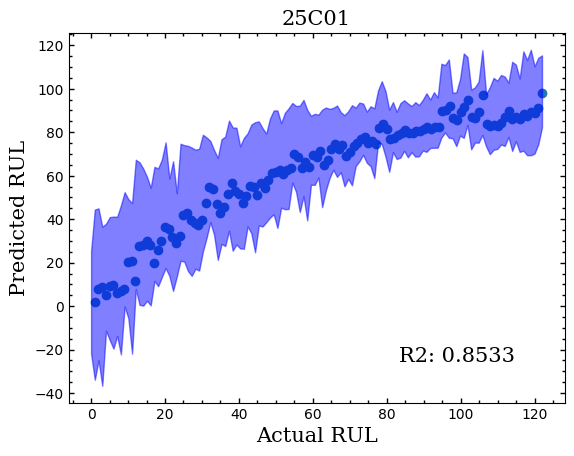

In [147]:
ID = 1
title_name = 1
result = []
x = torch.tensor(data[f"EIS{ID:02}"], dtype=torch.float32)
for k in range(n_splits):
    model.load_state_dict(torch.load(f"model_weights/CNNBiLSTM/RUL_128_drop_0.5_model{k}.pth",
                                      map_location=torch.device(device)))
    out = model(x.to(device))
    out = out.cpu()
    out = out.detach().numpy()
    out = scaler.inverse_transform(out)
    result.append(out)
result = np.array(result)
out = np.mean(result, axis=0)
out_upper = np.max(result, axis=0)
out_upper = np.squeeze(out_upper)
out_lower = np.min(result, axis=0)
out_lower = np.squeeze(out_lower)
true = data[f"Cap{ID:02}"]
true = scaler.inverse_transform(true)
MSE = mean_squared_error(out[start:], true[start:]) 
R2_result = r2_score(true[start:], out[start:]) 
RMSE_result = math.sqrt(MSE)
RMSE_str = "{:.4f}".format(RMSE_result)
R2_str = "{:.4f}".format(R2_result)
x = np.linspace(0,x.shape[0],x.shape[0])

plt.scatter(true[start:],out[start:])
plt.fill_between(x[:], out_upper[::-1], out_lower[::-1], color='blue', alpha=0.5)
plt.title(f"25C{title_name:02}",fontsize=15,fontdict={'fontname': 'serif'})
#plt.xlim(0,240)
#plt.ylim(0.3,1.05)

ax = plt.gca()
plt.text(0.9, 0.1, "R2: "+ R2_str, ha='right', va='bottom', transform=ax.transAxes,fontsize=15,fontdict={'fontname': 'serif'})
plt.tick_params(axis='both', which='both', direction='in', width=1, top=True, bottom=True, right=True, left=True)
plt.minorticks_on()
plt.xlabel('Actual RUL',fontsize=15,fontdict={'fontname': 'serif'})
plt.ylabel('Predicted RUL',fontsize=15,fontdict={'fontname': 'serif'})
plt.show()

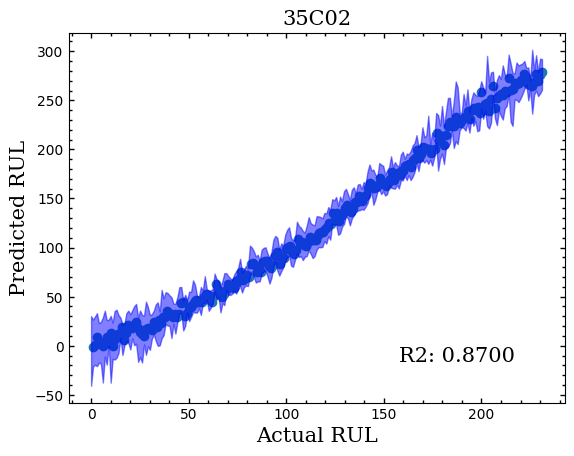

In [148]:
ID = 5
title_name = 2
result = []
x = torch.tensor(data[f"EIS{ID:02}"], dtype=torch.float32)
for k in range(n_splits):
    model.load_state_dict(torch.load(f"model_weights/CNNBiLSTM/RUL_128_drop_0.5_model{k}.pth",
                                      map_location=torch.device(device)))
    out = model(x.to(device))
    out = out.cpu()
    out = out.detach().numpy()
    out = scaler.inverse_transform(out)
    result.append(out)
result = np.array(result)
out = np.mean(result, axis=0)
out_upper = np.max(result, axis=0)
out_upper = np.squeeze(out_upper)
out_lower = np.min(result, axis=0)
out_lower = np.squeeze(out_lower)
true = data[f"Cap{ID:02}"]
true = scaler.inverse_transform(true)
MSE = mean_squared_error(out[start:], true[start:]) 
R2_result = r2_score(true[start:], out[start:]) 
RMSE_result = math.sqrt(MSE)
RMSE_str = "{:.4f}".format(RMSE_result)
R2_str = "{:.4f}".format(R2_result)
x = np.linspace(0,x.shape[0],x.shape[0])

plt.scatter(true[start:],out[start:])
plt.fill_between(x[:], out_upper[::-1], out_lower[::-1], color='blue', alpha=0.5)
plt.title(f"35C{title_name:02}",fontsize=15,fontdict={'fontname': 'serif'})
#plt.xlim(0,240)
#plt.ylim(0.3,1.05)

ax = plt.gca()
plt.text(0.9, 0.1, "R2: "+ R2_str, ha='right', va='bottom', transform=ax.transAxes,fontsize=15,fontdict={'fontname': 'serif'})
plt.tick_params(axis='both', which='both', direction='in', width=1, top=True, bottom=True, right=True, left=True)
plt.minorticks_on()
plt.xlabel('Actual RUL',fontsize=15,fontdict={'fontname': 'serif'})
plt.ylabel('Predicted RUL',fontsize=15,fontdict={'fontname': 'serif'})
plt.show()

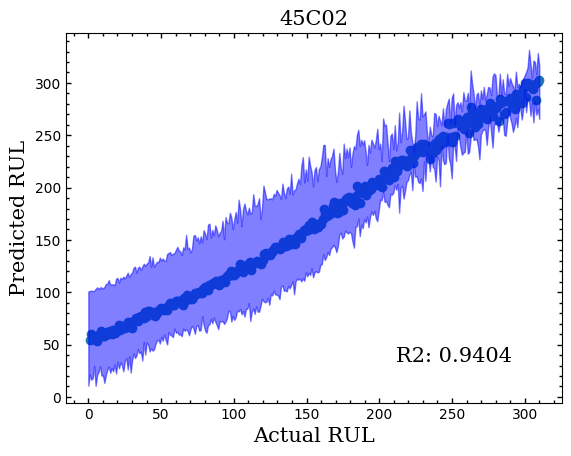

In [149]:
ID = 8
title_name = 2
result = []
x = torch.tensor(data[f"EIS{ID:02}"], dtype=torch.float32)
for k in range(n_splits):
    model.load_state_dict(torch.load(f"model_weights/CNNBiLSTM/RUL_128_drop_0.5_model{k}.pth",
                                      map_location=torch.device(device)))
    out = model(x.to(device))
    out = out.cpu()
    out = out.detach().numpy()
    out = scaler.inverse_transform(out)
    result.append(out)
result = np.array(result)
out = np.mean(result, axis=0)
out_upper = np.max(result, axis=0)
out_upper = np.squeeze(out_upper)
out_lower = np.min(result, axis=0)
out_lower = np.squeeze(out_lower)
true = data[f"Cap{ID:02}"]
true = scaler.inverse_transform(true)
MSE = mean_squared_error(out[start:], true[start:]) 
R2_result = r2_score(true[start:], out[start:]) 
RMSE_result = math.sqrt(MSE)
RMSE_str = "{:.4f}".format(RMSE_result)
R2_str = "{:.4f}".format(R2_result)
x = np.linspace(0,x.shape[0],x.shape[0])

plt.scatter(true[start:],out[start:])
plt.fill_between(x[:], out_upper[::-1], out_lower[::-1], color='blue', alpha=0.5)
plt.title(f"45C{title_name:02}",fontsize=15,fontdict={'fontname': 'serif'})
#plt.xlim(0,240)
#plt.ylim(0.3,1.05)

ax = plt.gca()
plt.text(0.9, 0.1, "R2: "+ R2_str, ha='right', va='bottom', transform=ax.transAxes,fontsize=15,fontdict={'fontname': 'serif'})
plt.tick_params(axis='both', which='both', direction='in', width=1, top=True, bottom=True, right=True, left=True)
plt.minorticks_on()
plt.xlabel('Actual RUL',fontsize=15,fontdict={'fontname': 'serif'})
plt.ylabel('Predicted RUL',fontsize=15,fontdict={'fontname': 'serif'})
plt.show()